In [1]:
import pandas as pd
from datetime import timedelta


signals = pd.read_csv('stochastic_4h_signals.csv', parse_dates=['timestamp'])[['timestamp','open', 'high', 'low','volume' ,'close', '%K','%D','Signal','SC_Signals']]
df = pd.read_csv('ohlc_1m_data_last_day.csv', parse_dates=['timestamp'])


In [12]:
import time
from turtle import back
import pandas as pd
import numpy as np
from datetime import timedelta, datetime

def ledger(signals, df, time_frame='4H'):
    """
    This function takes a dataframe of signals which is 4h interval data and df which is 1min interval data.
    """
    signals = signals
    df_1min = df
    action = []
    signal = []
    date_time = []
    buy_price = []
    sell_price = []
    pnl = []
    transaction_fee = 0.07 / 100
    profit_percentage = 0.05
    stop_loss_percentage = 0.02
    next_trade_time = None  # To store the time of the next trade

    def calculate_levels(buy, direction):
        if direction == 1:
            tp_price = buy + (buy * profit_percentage)
            sl_price = buy - (buy * stop_loss_percentage)
        elif direction == -1:
            tp_price = buy - (buy * profit_percentage)
            sl_price = buy + (buy * stop_loss_percentage)
        else:
            tp_price = sl_price = np.nan
        return tp_price, sl_price

    for i in range(len(signals)):
        if len(action) == 0 or (next_trade_time is not None and signals['timestamp'][i] >= next_trade_time):
            # Check and open a trade in the signal's direction
            if signals['Signal'][i] != 0:
                action.append(signals['Signal'][i])
                date_time.append(signals['timestamp'][i])
                buy_price.append(signals['open'][i])
                buy = signals['open'][i]
                if signals['Signal'][i] == 1:
                    signal.append('Buy')
                elif signals['Signal'][i] == -1:
                    signal.append('Sell')
                sell_price.append(np.nan)
                pnl.append(np.nan)
                next_trade_time = None
                tp_price, sl_price = calculate_levels(buy, signals['Signal'][i])
        else:
            if action[-1] == signals.iloc[i].Signal or signals['Signal'][i] == 0:
                if action[-1] == 1:
                    tp_price, sl_price = calculate_levels(buy, 1)
                elif action[-1] == -1:
                    tp_price, sl_price = calculate_levels(buy, -1)
                else:
                    continue 

                
                if i + 1 < len(signals):
                    next_signal_date = signals.loc[i + 1, 'timestamp']
                else:
                    next_signal_date = df_1min['timestamp'].max()

                end_datetime = signals.iloc[i]['timestamp']
                current_datetime = end_datetime - timedelta(hours=int(time_frame[0]))
                df_1min_slice = df_1min[(df_1min['timestamp'] >= current_datetime) & (df_1min['timestamp'] <= end_datetime)]
                df_1min_slice.reset_index(drop=True, inplace=True)

                for j in df_1min_slice.iterrows():
                    if j[1].high > tp_price and action[-1] == 1:
                        # Take profit
                        time = j[1].timestamp
                        sell_price.append(j[1].high)
                        action.append(action[-1])
                        signal.append('TP Hit')
                        date_time.append(time)
                        buy_price.append(np.nan)
                        pnl.append(np.nan)
                        next_trade_time = (pd.to_datetime(time) + pd.Timedelta(hours=(int(time_frame[0]) - pd.to_datetime(time).hour % 4))).replace(minute=0, second=0, microsecond=0)
                        break
                    elif j[1].low < sl_price and action[-1] == 1:
                        # Stop loss
                        time = j[1].timestamp
                        sell_price.append(j[1].low)
                        signal.append('SL Hit')
                        action.append(action[-1])
                        date_time.append(time)
                        buy_price.append(np.nan)
                        pnl.append(np.nan)
                        next_trade_time = (pd.to_datetime(time) + pd.Timedelta(hours=(int(time_frame[0]) - pd.to_datetime(time).hour % 4))).replace(minute=0, second=0, microsecond=0)
                        break
                    elif j[1].low < tp_price and action[-1] == -1:
                        # Take profit
                        time = j[1].timestamp
                        sell_price.append(j[1].low)
                        action.append(action[-1])
                        signal.append('TP Hit')
                        date_time.append(time)
                        buy_price.append(np.nan)
                        pnl.append(np.nan)
                        next_trade_time = (pd.to_datetime(time) + pd.Timedelta(hours=(int(time_frame[0]) - pd.to_datetime(time).hour % 4))).replace(minute=0, second=0, microsecond=0)
                        break
                    elif j[1].high > sl_price and action[-1] == -1:
                        # Stop loss
                        time = j[1].timestamp
                        sell_price.append(j[1].high)
                        action.append(action[-1])
                        signal.append('SL Hit')
                        date_time.append(time)
                        buy_price.append(np.nan)
                        pnl.append(np.nan)
                        next_trade_time = (pd.to_datetime(time) + pd.Timedelta(hours=(int(time_frame[0]) - pd.to_datetime(time).hour % 4))).replace(minute=0, second=0, microsecond=0)
                        break
            else:
                if action[-1] in ['tp hit', 'sl hit']:
                    if signals['Signal'][i] == 0:
                        continue  # Ignore if the new signal is 0
                    action.append(signals['Signal'][i])
                    date_time.append(signals['timestamp'][i])
                    buy_price.append(signals['open'][i])
                    signal.append('Buy')
                    buy = signals['open'][i]
                    sell_price.append(np.nan)
                    pnl.append(np.nan)
                    next_trade_time = None
                else:
                    action.append(signals['Signal'][i])
                    date_time.append(signals['timestamp'][i])
                    sell_price.append(signals['open'][i])
                    buy = signals['open'][i]
                    if signals['Signal'][i] == 1:
                        signal.append('Buy')
                    elif signals['Signal'][i] == -1:
                        signal.append('Sell')
                    buy_price.append(np.nan)
                    pnl.append(np.nan)

                    action.append(signals['Signal'][i])
                    date_time.append(signals['timestamp'][i])
                    buy_price.append(signals['open'][i])
                    buy = signals['open'][i]
                    if signals['Signal'][i] == 1:
                        signal.append('Buy')
                    elif signals['Signal'][i] == -1:
                        signal.append('Sell')
                    sell_price.append(np.nan)
                    pnl.append(np.nan)
                    
    # Creating the resulting dataframe
    ledger_df = pd.DataFrame({
        'date_time': date_time, 
        'signal': signal, 
        'action': action, 
        'buy_price': buy_price, 
        'sell_price': sell_price, 
        'pnl': pnl
    })
    ledger_df['action'] = ledger_df['action'].replace({1: 'Buy', -1: 'Sell', 0: 'Hold'})
    ledger_df['buy_price'] = ledger_df['buy_price'].fillna(method='ffill')
    ledger_df['signal'] = ledger_df['signal'].replace({1: 'Buy', -1: 'Sell', 0: 'Hold'})
    ledger_df['action'] = ledger_df['action'].replace({'Buy': 'Long', 'Sell': 'Short'})

    # Function to calculate PnL and balance
    def calculate_pnl_and_balance(df):
        balance = 1000  # Starting balance
        balances = []  # List to store balance after each transaction

        for index, row in df.iterrows():
            buy_price = float(row['buy_price'])
            sell_price = float(row['sell_price'])

            if pd.isna(sell_price) or pd.isna(buy_price):
                balances.append(balance)  # No change in balance
                continue

            if df.iloc[index-1]['signal'] == 'Buy':  # Long
                pnl_percent = ((sell_price - buy_price) / buy_price) * 100
            elif df.iloc[index-1]['signal'] == 'Sell':  # Short
                pnl_percent = ((buy_price - sell_price) / buy_price) * 100
            else:
                pnl_percent = 0

            pnl_change = balance * (pnl_percent / 100)  
            balance += pnl_change  
            balances.append(balance)  

            df.at[index, 'pnl'] = round(pnl_percent, 2)  

        df['balance'] = balances  
        return df

    
    ledger_with_pnl = calculate_pnl_and_balance(ledger_df.copy())  

    return ledger_with_pnl


result = ledger(temp1, temp2, '4H')
print(result)


              date_time  signal action  buy_price  sell_price    pnl  \
0   2024-05-01 00:00:00    Sell  Short   60757.87         NaN    NaN   
1   2024-05-01 04:00:00     Buy   Long   60757.87    60251.83   0.83   
2   2024-05-01 04:00:00     Buy   Long   60251.83         NaN    NaN   
3   2024-05-01 07:07:00  SL Hit   Long   60251.83    59040.00  -2.01   
4   2024-05-01 12:00:00     Buy   Long   57898.46         NaN    NaN   
..                  ...     ...    ...        ...         ...    ...   
482 2024-08-11 04:00:00     Buy   Long   61090.32         NaN    NaN   
483 2024-08-11 04:00:00  TP Hit   Long   61090.32   100000.00  63.69   
484 2024-08-11 12:00:00    Sell  Short   60660.00         NaN    NaN   
485 2024-08-11 12:06:00  TP Hit  Short   60660.00    50000.01  17.57   
486 2024-08-11 20:00:00    Sell  Short   59606.46         NaN    NaN   

         balance  
0    1000.000000  
1    1008.328798  
2    1008.328798  
3     988.048532  
4     988.048532  
..           ...  
48

C:\Users\MTariq\AppData\Local\Temp\ipykernel_6284\947163611.py:161: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ledger_df['buy_price'] = ledger_df['buy_price'].fillna(method='ffill')


In [10]:
temp1 = signals[9491:].copy().reset_index(drop = True)
temp1

,timestamp,open,high,low,volume,close,%K,%D,Signal,SC_Signals
0,2024-05-01 00:00:00,60757.87,60841.63,59590.00,3099.42648,60272.00,77.077192,88.019238,-1,Sell
1,2024-05-01 04:00:00,60251.83,60334.76,57103.99,6981.68221,57499.99,26.528138,12.917558,1,Buy
2,2024-05-01 08:00:00,57544.81,57909.00,56565.32,6928.92487,57908.99,99.996390,83.142221,1,Buy
3,2024-05-01 12:00:00,57898.46,58251.11,56771.61,4892.76700,56873.93,49.888703,23.167551,1,Buy
4,2024-05-01 16:00:00,56886.00,59468.00,56625.09,8150.79456,56954.47,7.354738,6.860104,1,Buy
...,...,...,...,...,...,...,...,...,...,...
449,2024-08-11 04:00:00,61090.32,100000.00,33000.00,12.12191,61244.04,80.259713,75.849545,1,Buy
450,2024-08-11 08:00:00,61257.01,200000.00,45637.45,36.71237,60625.65,0.360235,0.359091,1,Buy
451,2024-08-11 12:00:00,60660.00,200000.00,33000.00,40.55435,60040.01,97.950847,98.470440,-1,Sell
452,2024-08-11 16:00:00,60110.63,74902.61,21683.75,28.06371,59694.05,97.883348,98.182939,-1,Sell


In [11]:
temp2 = df [2278080:].copy().reset_index(drop=True)
temp2

,timestamp,open,high,low,close,volume
0,2024-05-01 00:00:00,60672.01,60750.00,60660.98,60742.33,55.30759
1,2024-05-01 00:01:00,60742.33,60779.52,60721.76,60757.86,15.62630
2,2024-05-01 00:02:00,60757.87,60757.87,60675.20,60678.13,38.57373
3,2024-05-01 00:03:00,60678.13,60709.96,60675.21,60709.96,9.00795
4,2024-05-01 00:04:00,60709.96,60728.00,60688.39,60688.39,27.67657
...,...,...,...,...,...,...
148316,2024-08-11 23:56:00,58793.21,58794.13,50000.00,58761.28,1.27200
148317,2024-08-11 23:57:00,58749.75,58843.46,50000.00,58717.27,0.36614
148318,2024-08-11 23:58:00,58717.27,58717.27,58700.39,58713.73,0.13860
148319,2024-08-11 23:59:00,58715.99,58718.00,58680.11,58711.99,0.21365


# tp sl calculate the Stocket ocsillator indicator

In [5]:

ledger_df = ledger(signals, df)

Ledger DataFrame columns: Index(['date_time', 'action', 'signal', 'buy_price', 'sell_price', 'pnl'], dtype='object')
Ledger DataFrame head:
             date_time  action signal  buy_price  sell_price  pnl
0 2020-01-01 00:00:00      -1   Sell    7183.62         NaN  NaN
1 2020-01-01 08:00:00       1    Buy        NaN     7201.56  NaN
2 2020-01-01 08:00:00       1    Buy    7201.56         NaN  NaN
3 2020-01-02 08:00:00      -1   Sell        NaN     7125.00  NaN
4 2020-01-02 08:00:00      -1   Sell    7125.00         NaN  NaN


C:\Users\MTariq\AppData\Local\Temp\ipykernel_4780\3515514814.py:165: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ledger_df['buy_price'] = ledger_df['buy_price'].fillna(method='ffill')


In [13]:
result.head(30)

,date_time,signal,action,buy_price,sell_price,pnl,balance
0,2024-05-01 00:00:00,Sell,Short,60757.87,NaN,NaN,1000.000000
1,2024-05-01 04:00:00,Buy,Long,60757.87,60251.83,0.83,1008.328798
2,2024-05-01 04:00:00,Buy,Long,60251.83,NaN,NaN,1008.328798
3,2024-05-01 07:07:00,SL Hit,Long,60251.83,59040.00,-2.01,988.048532
4,2024-05-01 12:00:00,Buy,Long,57898.46,NaN,NaN,988.048532
5,2024-05-01 15:19:00,SL Hit,Long,57898.46,56674.51,-2.11,967.161587
6,2024-05-01 20:00:00,Buy,Long,57186.68,NaN,NaN,967.161587
7,2024-05-02 00:00:00,Sell,Short,57186.68,58600.01,2.47,991.064329
8,2024-05-02 00:00:00,Sell,Short,58600.01,NaN,NaN,991.064329
9,2024-05-02 04:00:00,Buy,Long,58600.01,57475.13,1.92,1010.088702


C:\Users\MTariq\AppData\Local\Temp\ipykernel_6284\947163611.py:161: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ledger_df['buy_price'] = ledger_df['buy_price'].fillna(method='ffill')


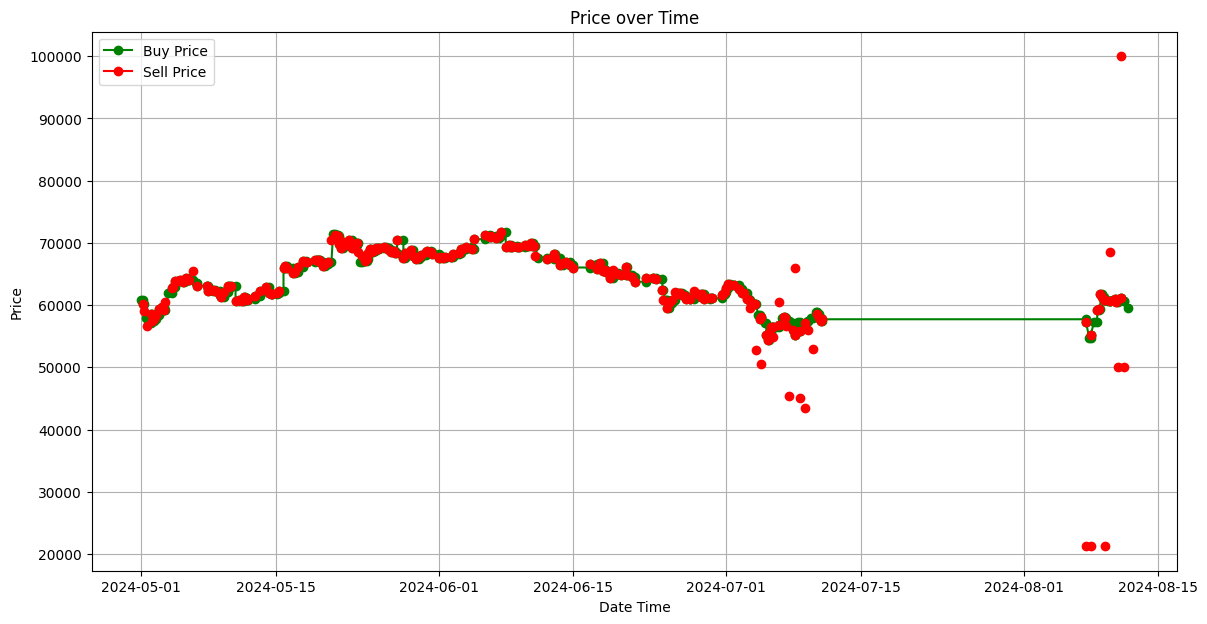

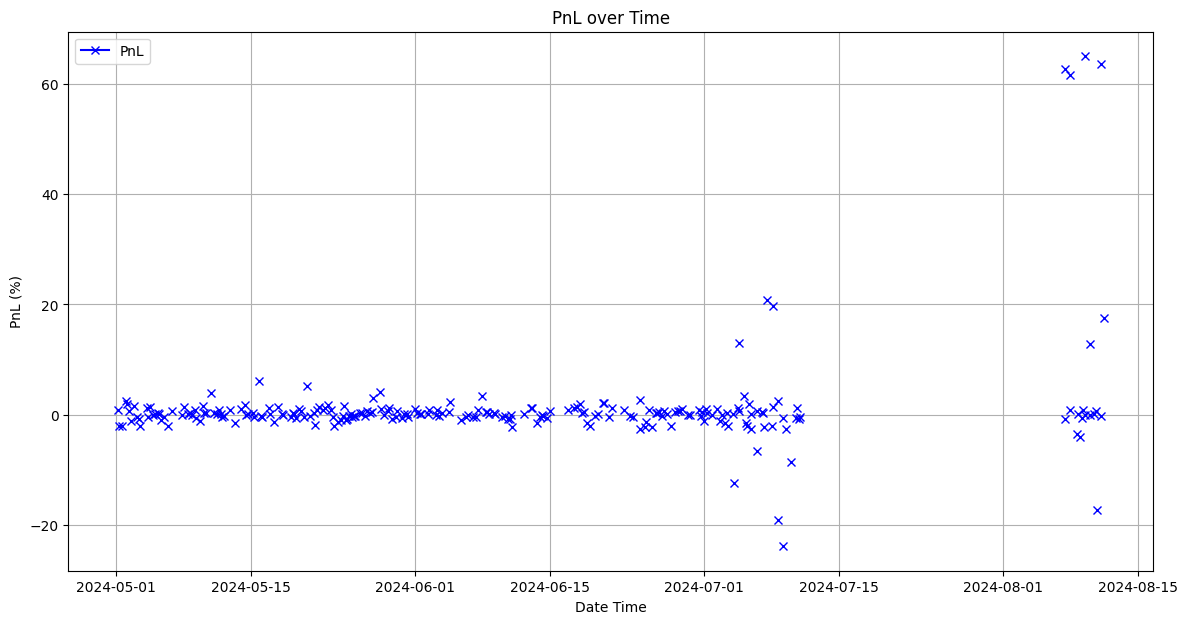

In [14]:
import matplotlib.pyplot as plt

def visualize_price_and_pnl(ledger_df):
    # Plot the buy and sell prices over time
    plt.figure(figsize=(14, 7))

    # Plotting buy prices
    plt.plot(result['date_time'], result['buy_price'], marker='o', linestyle='-', color='green', label='Buy Price')
    
    # Plotting sell prices
    plt.plot(result['date_time'], result['sell_price'], marker='o', linestyle='-', color='red', label='Sell Price')
    
    # Adding titles and labels
    plt.title('Price over Time')
    plt.xlabel('Date Time')
    plt.ylabel('Price')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Plot the PnL over time
    plt.figure(figsize=(14, 7))
    
    # Plotting PnL
    plt.plot(result['date_time'], result['pnl'], marker='x', linestyle='-', color='blue', label='PnL')
    
    # Adding titles and labels
    plt.title('PnL over Time')
    plt.xlabel('Date Time')
    plt.ylabel('PnL (%)')
    plt.legend()
    plt.grid(True)
    plt.show()

# Example usage:
# Assuming ledger_df is your DataFrame
ledger_df = ledger(temp1, temp2)  # Replace signals and df with your actual data
visualize_price_and_pnl(result)
